In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import statsmodels.api as sm
from statsmodels.api import tsa
import pandas.tseries.holiday as hol
from statsmodels.graphics.tsaplots import month_plot

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns=100

In [2]:
df = pd.read_csv('TSLA.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2956 entries, 0 to 2955
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2956 non-null   object 
 1   Open       2956 non-null   float64
 2   High       2956 non-null   float64
 3   Low        2956 non-null   float64
 4   Close      2956 non-null   float64
 5   Adj Close  2956 non-null   float64
 6   Volume     2956 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 161.8+ KB


In [5]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2956.000000,2956.000000,2956.000000,2956.000000,2956.000000,2.956000e+03
mean,138.691296,141.771603,135.425953,138.762183,138.762183,3.131449e+07
std,250.044839,255.863239,243.774157,250.123115,250.123115,2.798383e+07
min,3.228000,3.326000,2.996000,3.160000,3.160000,5.925000e+05
25%,19.627000,20.402000,19.127500,19.615000,19.615000,1.310288e+07
50%,46.656999,47.487001,45.820002,46.545000,46.545000,2.488680e+07
75%,68.057001,69.357500,66.911501,68.103998,68.103998,3.973875e+07
max,1234.410034,1243.489990,1217.000000,1229.910034,1229.910034,3.046940e+08


Looks like we have no columns missing values, but we need to convert the `Date` column to date type and setting it as index

# Dealing Date Column

In [6]:
# convert Date to correct data type
df['Date'] = pd.to_datetime(df['Date'])

In [7]:
# setting Date as index
df = df.set_index('Date')

# check
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [8]:
# check the time span of the dataset
df.index

DatetimeIndex(['2010-06-29', '2010-06-30', '2010-07-01', '2010-07-02',
               '2010-07-06', '2010-07-07', '2010-07-08', '2010-07-09',
               '2010-07-12', '2010-07-13',
               ...
               '2022-03-11', '2022-03-14', '2022-03-15', '2022-03-16',
               '2022-03-17', '2022-03-18', '2022-03-21', '2022-03-22',
               '2022-03-23', '2022-03-24'],
              dtype='datetime64[ns]', name='Date', length=2956, freq=None)

In [9]:
first_day = df.index.min()
last_day = df.index.max()

# pands 'Timestamp' objects
first_day, last_day

(Timestamp('2010-06-29 00:00:00'), Timestamp('2022-03-24 00:00:00'))

In [10]:
last_day - first_day

Timedelta('4286 days 00:00:00')

First, we will check if there are any dates misisng from the index, or if we have a record for each day between the first recorded day and the last. We can construct the full date range between the first and last observation date and see the difference with the index.

In [11]:
full_range = pd.date_range(start=first_day, end=last_day, freq='D')

full_range.difference(df.index)

DatetimeIndex(['2010-07-03', '2010-07-04', '2010-07-05', '2010-07-10',
               '2010-07-11', '2010-07-17', '2010-07-18', '2010-07-24',
               '2010-07-25', '2010-07-31',
               ...
               '2022-02-20', '2022-02-21', '2022-02-26', '2022-02-27',
               '2022-03-05', '2022-03-06', '2022-03-12', '2022-03-13',
               '2022-03-19', '2022-03-20'],
              dtype='datetime64[ns]', length=1331, freq=None)

There are 1331 days over the 11 years that are missing from the dataset. We will add these dates to the index to check if there is any pattern in these missing dates, so we can deal with them accordingly or leave as them is.

In [12]:
# make a copy
df1 = df.copy()

In [13]:
df1 = df1.reindex(full_range)

In [14]:
df1[df1.isna().any(axis=1)].head(10)

,Open,High,Low,Close,Adj Close,Volume
2010-07-03,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-04,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-05,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-10,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-11,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-17,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-18,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-24,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-25,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-31,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# get the day of week for the missing dates
df1['day_of_week'] = df1.index.day_name()

In [16]:
null_rows = df1[df1.isna().any(axis=1)]

In [17]:
display(null_rows)

,Open,High,Low,Close,Adj Close,Volume,day_of_week
2010-07-03,NaN,NaN,NaN,NaN,NaN,NaN,Saturday
2010-07-04,NaN,NaN,NaN,NaN,NaN,NaN,Sunday
2010-07-05,NaN,NaN,NaN,NaN,NaN,NaN,Monday
2010-07-10,NaN,NaN,NaN,NaN,NaN,NaN,Saturday
2010-07-11,NaN,NaN,NaN,NaN,NaN,NaN,Sunday
...,...,...,...,...,...,...,...
2022-03-06,NaN,NaN,NaN,NaN,NaN,NaN,Sunday
2022-03-12,NaN,NaN,NaN,NaN,NaN,NaN,Saturday
2022-03-13,NaN,NaN,NaN,NaN,NaN,NaN,Sunday
2022-03-19,NaN,NaN,NaN,NaN,NaN,NaN,Saturday


The majority of missing dates correspond to Saturdays and Sundays, consistent with the closure of stock exchanges such as the NYSE and NASDAQ on weekends, which results in no recorded trading activities. Additionally, we note the absence of data on certain weekdays, such as July 5 and September 6, 2010, both of which are Mondays. This absence aligns with U.S. civic holidays, when long weekends typically extend to include Mondays. We will conduct a detailed investigation to identify any missing dates that do not fall on weekends or recognized holidays to ascertain the reasons behind the lack of data on standard trading days.

In [18]:
# get missing dates that are weekdays
missing_weekdays = null_rows[~null_rows['day_of_week'].isin(['Saturday','Sunday','Monday'])]

missing_weekdays.head(10)

,Open,High,Low,Close,Adj Close,Volume,day_of_week
2010-11-25,NaN,NaN,NaN,NaN,NaN,NaN,Thursday
2010-12-24,NaN,NaN,NaN,NaN,NaN,NaN,Friday
2011-04-22,NaN,NaN,NaN,NaN,NaN,NaN,Friday
2011-11-24,NaN,NaN,NaN,NaN,NaN,NaN,Thursday
2012-04-06,NaN,NaN,NaN,NaN,NaN,NaN,Friday
2012-07-04,NaN,NaN,NaN,NaN,NaN,NaN,Wednesday
2012-10-30,NaN,NaN,NaN,NaN,NaN,NaN,Tuesday
2012-11-22,NaN,NaN,NaN,NaN,NaN,NaN,Thursday
2012-12-25,NaN,NaN,NaN,NaN,NaN,NaN,Tuesday
2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,Tuesday


In [19]:
# instantiate US federal holiday calendar
us_calendar = hol.USFederalHolidayCalendar()

# get the holidays within the date range
us_holidays = us_calendar.holidays(start=df1.index.min(),end=df1.index.max())

In [20]:
# check if missing dates are US federal holidays
missing_weekdays['is_holiday'] = missing_weekdays.index.isin(us_holidays)

missing_weekdays

,Open,High,Low,Close,Adj Close,Volume,day_of_week,is_holiday
2010-11-25,NaN,NaN,NaN,NaN,NaN,NaN,Thursday,True
2010-12-24,NaN,NaN,NaN,NaN,NaN,NaN,Friday,True
2011-04-22,NaN,NaN,NaN,NaN,NaN,NaN,Friday,False
2011-11-24,NaN,NaN,NaN,NaN,NaN,NaN,Thursday,True
2012-04-06,NaN,NaN,NaN,NaN,NaN,NaN,Friday,False
2012-07-04,NaN,NaN,NaN,NaN,NaN,NaN,Wednesday,True
2012-10-30,NaN,NaN,NaN,NaN,NaN,NaN,Tuesday,False
2012-11-22,NaN,NaN,NaN,NaN,NaN,NaN,Thursday,True
2012-12-25,NaN,NaN,NaN,NaN,NaN,NaN,Tuesday,True
2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,Tuesday,True


There are still some missing dates are categorized as not an US holidays. We see a lot of non-holiday weekdays are around end of March or start of April, after searching them manually, these dates are in observance of Good Friday. Although Good Friday is not a federal holiday in the U.S., the NYSE, NASDAQ, and other stock markets are traditionally shut down on this day.

Some discrepancies: 
- 2012-10-30: Due to Hurricane Sandy, the stock markets were shut down to ensure the safety of individuals and the integrity of the market.
- 2018-12-05: The stock markets were closed on this day, as a mourning for former President George H.W. Bush. It is a tradition in the U.S. to close the stock markets as part of a national day of mourning when a former president dies.

Now, we concluded that the missing dates are indeed weekends, federal holidays, or special events. Thus, we will leave them as for now, as they are not anomalies.

# EDA

In [21]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


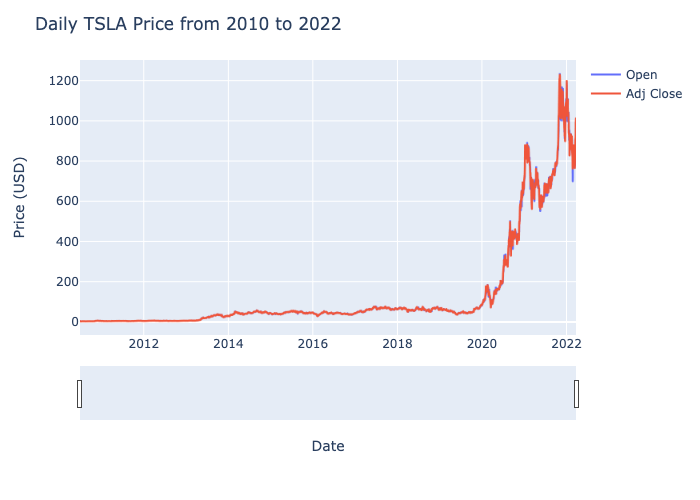

In [22]:
# plot open and adj close prices
fig = px.line(df,
             x=df.index,
             y=['Open','Adj Close']
             )

fig.update_layout(yaxis_title='Price (USD)',
                 legend_title='',
                 title='Daily TSLA Price from 2010 to 2022')

fig.update_xaxes(rangeslider_visible=True)

fig.show('png')

**Observations:**
- **Overall Trend:** We see a clear upward trend in the opening and adjusted closing prices, indicating a strong increase in the stock's value. 
- **Volatility:** There are peroids of volatility, as seen in the fluctuations between the opening and adjusted closing prices. The fluctuations are tpical in the stock market and can be influenced by a variety of factors including market sentiment, news related to the company, and broader economic conditions.
- **Major Growth Phases:** The stock experienced several major growth phases, particularly noticeable from mid-2020 onwards, where both the opening and adjusted closing prices surged dramatically. This period likely corresponds with significant company milestones, increased production capabilities, or other positive market influences.
- **Correlation Between Open and Adj Close Prices:** The opening and adjusted closing prices closely track each other throughout the entire period, which is expected as both reflect daily price movements. However, the adjusted closing price accounts for any corporate actions such as stock splits or dividends, providing a more accurate reflection of the stock's value over time.
- **Notable Dips:** While the overall trend is upward, there are several noticeable dips or corrections in the stock price. These could be due to a variety of factors, including market corrections, negative news, or broader economic downturns. Each dip is followed by a recovery, indicating strong market confidence in the stock over the long term.

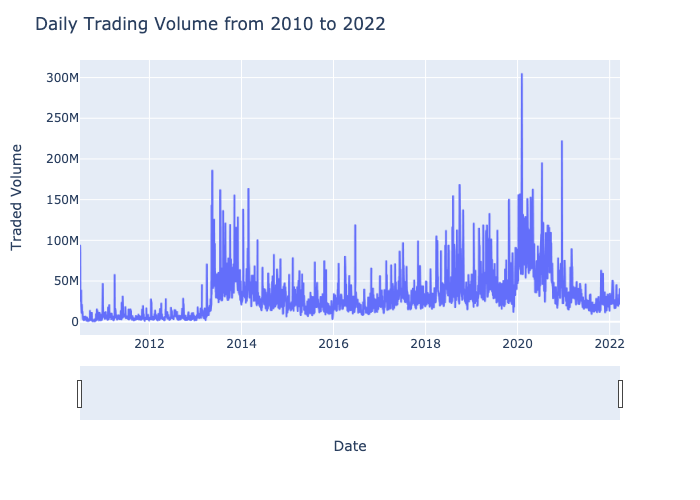

In [23]:
# plot volume of shares traded daily from 2010 to 2022
fig = px.line(df,
             x=df.index,
             y=['Volume']
             )

fig.update_layout(yaxis_title='Traded Volume',
                 title='Daily Trading Volume from 2010 to 2022',
                 showlegend=False)

fig.update_xaxes(rangeslider_visible=True)

fig.show('png')

**Observations:**
- **Trend Over Time:** Initially, from 2010 until around late 2013, the traded volume shows relatively low and consistent levels. Starting from 2014, there is a noticeable increase in trading activity, with several spikes indicating days of particularly high volume.
    - Model S Success: Tesla's Model S had been on the market for about a year and was receiving positive reviews for its performance, safety, and technology. It was named Motor Trend's 2013 Car of the Year, which was announced in late 2012 and continued to boost the company's reputation throughout 2013.
    - Supercharger Network Expansion: Tesla continued to expand its Supercharger network in 2013 and 2014, significantly improving the practicality of owning electric vehicles by enabling longer trips and faster charging times.
    - Profitability: In 2013, Tesla reported its first quarterly profit in Q1, a significant milestone that helped improve investor confidence in the company's long-term viability.
    - Battery Technology and Gigafactory Plans: Elon Musk, Tesla's CEO, discussed plans for a Gigafactory to produce battery cells in high volume, aiming to reduce battery costs significantly. The announcement of these plans contributed to investor optimism about Tesla's future growth.
- **Peak Trading Periods:** There are notable peaks in trading volume, particularly around the mid-2010s and another significant peak in Feburary 2020. These could be related to specific company milestones, product launches, earnings reports, or external market conditions affecting investor sentiment and trading behavior.
    -Stock Performance: Tesla's stock saw an extraordinary rise throughout 2020, with its market capitalization surpassing that of many established automotive companies. The stock was also split 5-for-1 at the end of August to make it more accessible to individual investors.
    - Production and Delivery Milestones: Tesla reported record-breaking production and delivery numbers in 2020, significantly increGlobal Expansion and Production Milestones: Tesla was also making significant progress on its global expansion, with the Shanghai Gigafactory starting to ramp up production, which contributed to the positive outlook on the company's future growth.
    - Exceptional Q4 2019 Earnings Report: Tesla reported its Q4 2019 earnings in late January 2020, which exceeded Wall Street expectations. The company announced significant profits and a record number of vehicle deliveries. This positive financial report drove investor enthusiasm and increased trading activity.
    - Growing Confidence in Electric Vehicles (EV) Market: Tesla's success and visibility have been closely tied to the broader electric vehicle market's growth prospects. In early 2020, there was growing optimism about the EV sector, partly due to environmental concerns and advancements in battery technology. Tesla, being a leader in this space, benefited from this trend.
    - Full Self-Driving (FSD) Beta Release: Tesla released the beta version of its Full Self-Driving software to a small group of testers. This was a step forward in Tesla's ambition to achieve fully autonomous driving, although it also attracted scrutiny and regulatory attention.
- **Recent Trends:** Toward the latter part of the graph, around 2021 and into 2022, there appears to be a general decline in trading volume compared to the peak periods previously observed. This could indicate a normalization of trading activity after periods of high volatility or significant market events.

**Note:** For the stock time series data, we should focus on the adjusted closing price, as the adjusted closing price accounts for dividends distributed by the company. When a stock pays dividends, its price typically drops by the dividend amount on the ex-dividend date, but this drop does not reflect a decrease in the value of the company. The adjusted closing price factors in this dividend payment, providing a clearer picture of the stock's value over time.

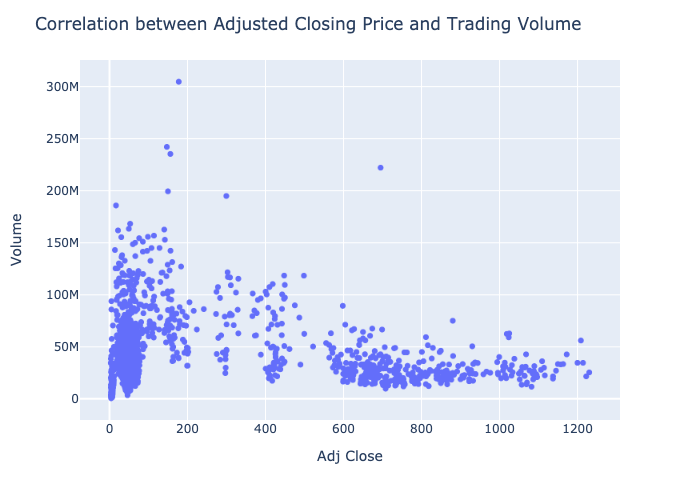

In [24]:
fig = px.scatter(df,
                y=df['Volume'],
                x=df['Adj Close'])

fig.update_layout(title='Correlation between Adjusted Closing Price and Trading Volume')

fig.show('png')

**Observation:**
-  A significant number of data points are clustered at lower trading volumes, particularly below 100 million shares. This indicates that on many trading days, the volume was relatively low.
- There's a wide range of adjusted closing prices, with a significant concentration of data points in the lower price range, indicating that the stock price was often lower. However, there are also data points extending up to an adjusted closing price of around 1200, showing that the stock reached higher prices on some occasions.
- Overall, the scatter plot does not show a clear linear correlation between trading volume and adjusted closing price. While there's a wide dispersion of prices at lower volumes, higher volumes don't consistently correspond to higher or lower prices. However, trading valumes tend to be lower when the stock price increases, indicating that investor activity in terms of share trading may decrease as the stock price reaches higher levels. This trend could suggest that as prices climb, fewer investors are willing to buy or sell at those levels, possibly due to perceived overvaluation or a wait-and-see approach in anticipation of a market correction. Conversely, lower stock prices might encourage higher trading volumes as investors perceive a buying opportunity or seek to offload shares amid declining values.


# Monthly Trend

In [25]:
df_monthly = df.resample('MS').sum()

df_monthly.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-01,8.958,11.084,8.168,9.544,9.544,179767000
2010-07-01,84.308,86.688,79.028,82.144,82.144,322879000
2010-08-01,86.000,87.604,83.954,85.848,85.848,75191000
2010-09-01,87.272,89.360,85.298,87.110,87.110,90229500
2010-10-01,87.038,88.170,85.788,86.996,86.996,32739000


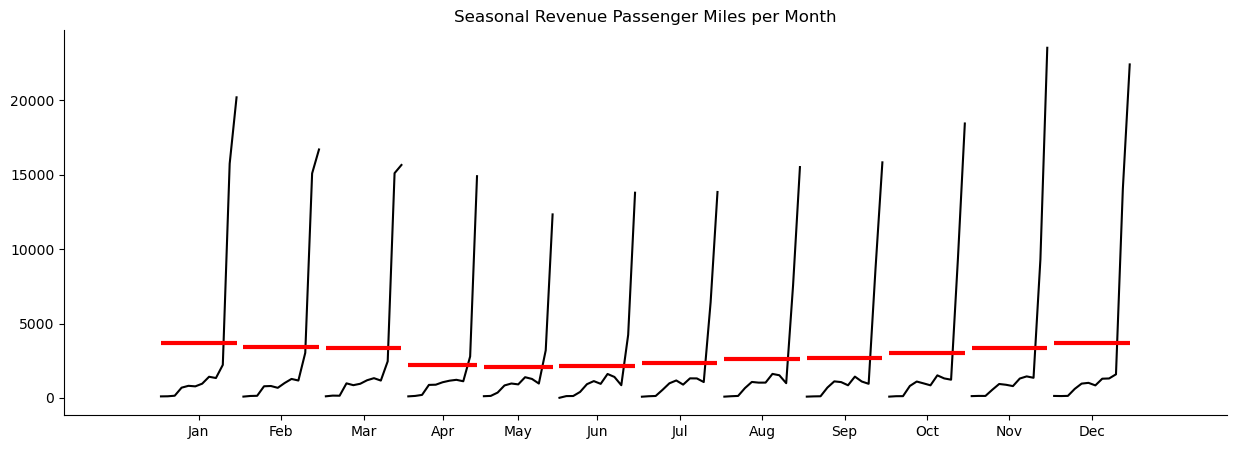

In [26]:
# create the seasonal plot

plt.figure(figsize=(15, 5))

month_plot(df_monthly["Adj Close"], ax=plt.gca())

plt.title("Seasonal Revenue Passenger Miles per Month")
sns.despine()

plt.show()

The red bars show the average for the given month across al years, while each black line represent an individual month and the progression of values across the years.
We can see the upward trend for each month and that on average, the end and the beginning of the year Tesla's stock closing price are higher.

In [27]:
# get monthly average closig price
monthly_mean = df_monthly.groupby(df_monthly.index.month_name()).mean()

# relative deviation from the overall mean
monthly_mean_diff = (monthly_mean-monthly_mean.mean())/monthly_mean

# month names in right order
month_names = pd.date_range(start='2000-01', freq='M', periods=12).month_name()

# reorder columns to follow the month order
monthly_mean_diff = monthly_mean_diff.loc[month_names, ]

# month names in right order
monthly_mean_diff

,Open,High,Low,Close,Adj Close,Volume
January,0.226695,0.227984,0.223083,0.224354,0.224354,-0.036465
February,0.156572,0.158871,0.153340,0.155390,0.155390,0.014199
March,0.139706,0.143627,0.133231,0.138809,0.138809,0.053653
April,-0.295115,-0.296162,-0.292101,-0.295181,-0.295181,0.095632
May,-0.404478,-0.408358,-0.401820,-0.407423,-0.407423,0.158103
June,-0.352760,-0.357216,-0.342555,-0.350847,-0.350847,-0.001402
July,-0.236666,-0.238359,-0.237156,-0.238993,-0.238993,0.039060
August,-0.106845,-0.108925,-0.098488,-0.102379,-0.102379,-0.008681
September,-0.078786,-0.081874,-0.077459,-0.078569,-0.078569,-0.125438
October,0.037232,0.035105,0.045298,0.039209,0.039209,-0.005481


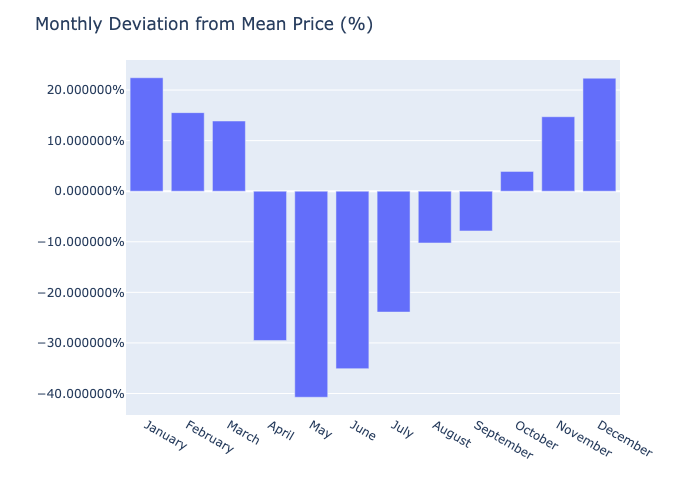

In [28]:
fig = px.bar(monthly_mean_diff['Adj Close'])
                              
fig.update_layout(
    yaxis_title="", 
    yaxis_tickformat = '%',
    xaxis_title="",
    title="Monthly Deviation from Mean Price (%)",
    showlegend=False,
)

fig.show('png')

- As previously discuessed, January, February, October, November, and December bring above average adjusted closing price. January and December both show 22% higher on average price
- April, May, June, and July are significantly below average, some potential reasons:
    - The automotive industry, including electric vehicles, may experience seasonal variations in sales, production, or supply chain dynamics, which could impact Tesla's financial performance and stock price.
    - Companies typically release their quarterly earnings reports a few weeks after a quarter ends. If Tesla’s earnings reports for Q1 (April) or Q2 (July) show below-expected performance, this could negatively impact stock prices.

# Trend-Seasonal Decomposition

A fundamental step in understanding seasonal patterns in any time series data is the trend-seasonal decomposition. Here, we extract three series from our original observation: 
- a trend component $T_t$ calculated using a moving average,
- a seasonal component $S_t$ which is the monthly/daily average of the de-trended series, and
- the residual $R_t$ that remains after subtracting the trend and seasonal component from the original series.

Adding up these three components will give back the original series:

$$y_t = T_t + S_t + R_t$$

There are different approaches for computing the trend and seasonal components, but the most standard method is implemented by the `seasonal_decompose` function from the time series analysis module of `statsmodels`. 

In [29]:
# decompose the time series
decomposition = tsa.seasonal_decompose(df_monthly['Adj Close'],model='additive')

In [30]:
# add the decomposition data to the original data set
df_monthly['Trend'] = decomposition.trend
df_monthly['Seasonal'] = decomposition.seasonal
df_monthly['Residual'] = decomposition.resid

df_monthly.head(10)

,Open,High,Low,Close,Adj Close,Volume,Trend,Seasonal,Residual
Date,,,,,,,,,
2010-06-01,8.958,11.084,8.168,9.544,9.544,179767000,NaN,-229.873975,NaN
2010-07-01,84.308,86.688,79.028,82.144,82.144,322879000,NaN,-187.183337,NaN
2010-08-01,86.000,87.604,83.954,85.848,85.848,75191000,NaN,-12.531216,NaN
2010-09-01,87.272,89.360,85.298,87.110,87.110,90229500,NaN,-71.582626,NaN
2010-10-01,87.038,88.170,85.788,86.996,86.996,32739000,NaN,29.248404,NaN
2010-11-01,120.066,125.454,116.460,121.976,121.976,141575500,NaN,-140.048137,NaN
2010-12-01,134.966,137.648,130.102,133.270,133.270,184464500,98.699917,245.680902,-211.110819
2011-01-01,103.230,104.716,100.558,102.572,102.572,142100500,104.727333,347.103722,-349.259055
2011-02-01,88.902,90.770,86.754,88.668,88.668,146517500,107.220417,224.614981,-243.167398


The null values are due to the fact that the trend component is calculated with a rolling average that is not defined at the beginning and the end of the series.

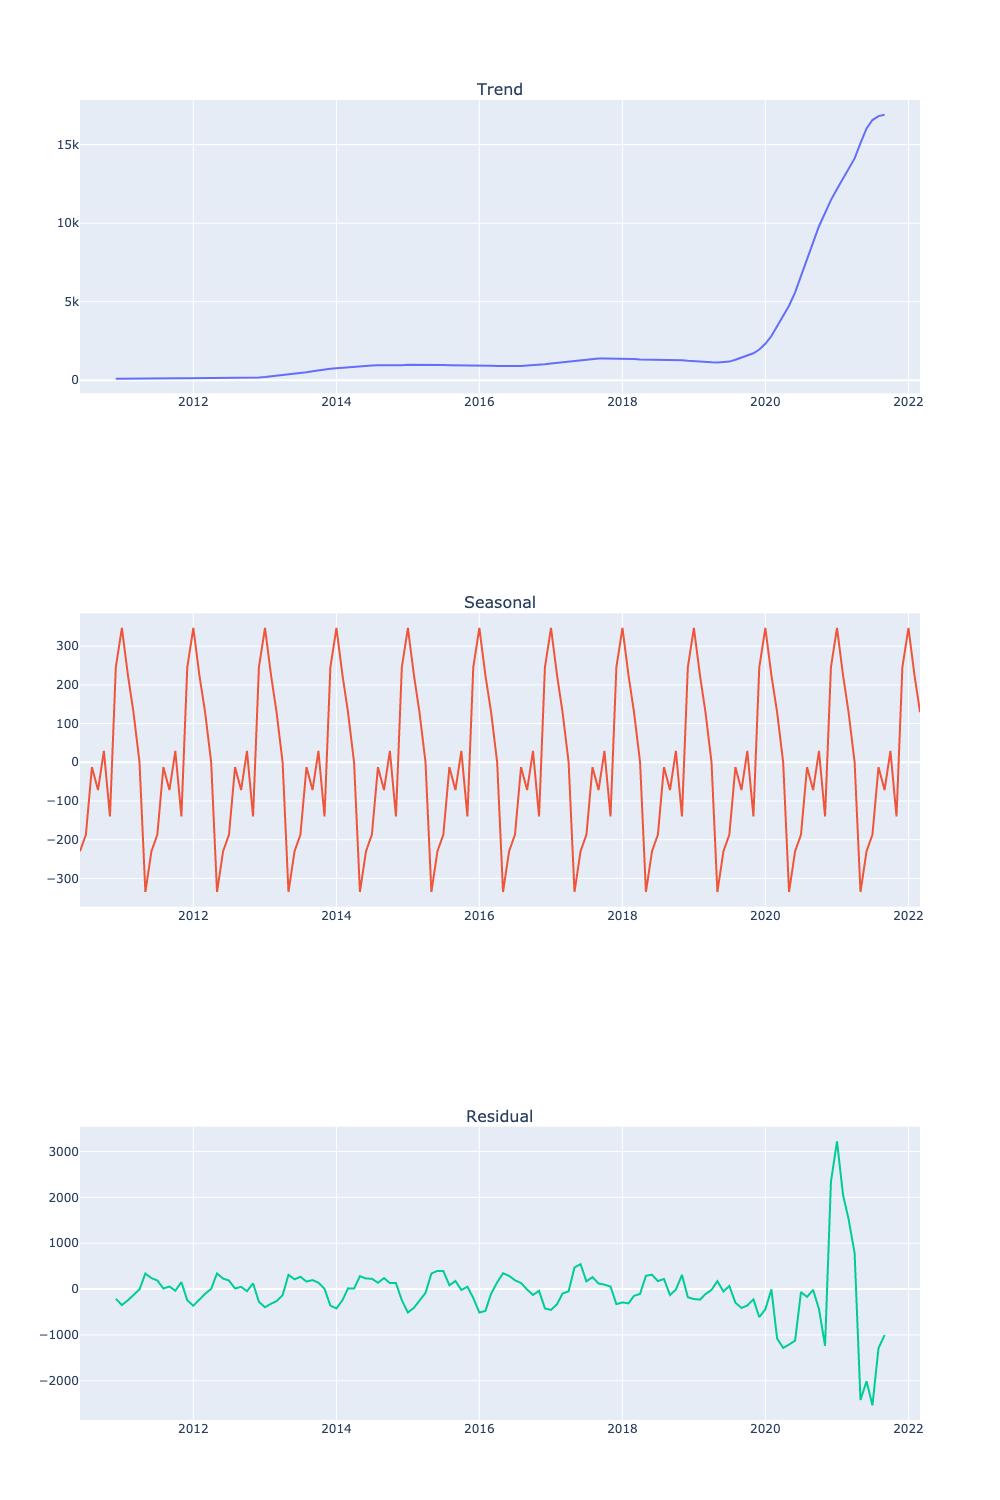

In [31]:
# plot decomposition data

decom_cols = ['Trend','Seasonal','Residual']

fig = make_subplots(rows=3,
                   cols=1,
                   subplot_titles=decom_cols)

for i,col in enumerate(decom_cols):
    fig.add_trace(go.Scatter(x=df_monthly.index,
                            y=df_monthly[col]),
                  row=i+1,
                  col=1)

fig.update_layout(height=1500,width=1000,showlegend=False)
fig.show('png')

**Observations:**
- The trend is decidedly upward, with a noticeable phase where the adjusted closing price gradually rose and then leveled off from late 2010 through to the end of 2019. This was succeeded by a sharp, almost linear surge. Starting from the summer of 2021, indications of a new leveling phase are apparent.
- The seasonal plot shows excatly what we observed in previous bar chart for monthly differences.
- In the residual plot we can see there is still some seasonality. In general, it would be ideal to have that information captured by the seasonal component.We also see some heteroscedasticity (changing variance) in the residual component. There are more advanced decomposition techniques that can account for such affects and extract a changing seasonal component.